# ABC calibration of $I_\text{CaL}$ in Nygren model to original dataset.

In [4]:
import os, tempfile
import logging
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC.experiment import setup
from ionchannelABC.visualization import plot_sim_results, plot_kde_matrix_custom
import myokit

In [6]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

## Initial set-up

Load experiments used for original dataset calibration:
 - Steady-state activation [Mewes1994]
 - Steady-state inactivation [Li1997]
 - Inactivation time constant (fast+slow) [Li1997]
 - Recovery time constant (fast+slow) [Li1997]

In [7]:
from experiments.ical_mewes import mewes_act
from experiments.ical_li import (li_inact_1000,
                                 li_inact_kin_80,
                                 li_recov)

Load the myokit modelfile for this channel.

In [8]:
modelfile = 'models/nygren_ical.mmt'

## Plot steady-state and time constant functions of original model

In [9]:
from ionchannelABC.visualization import plot_variables

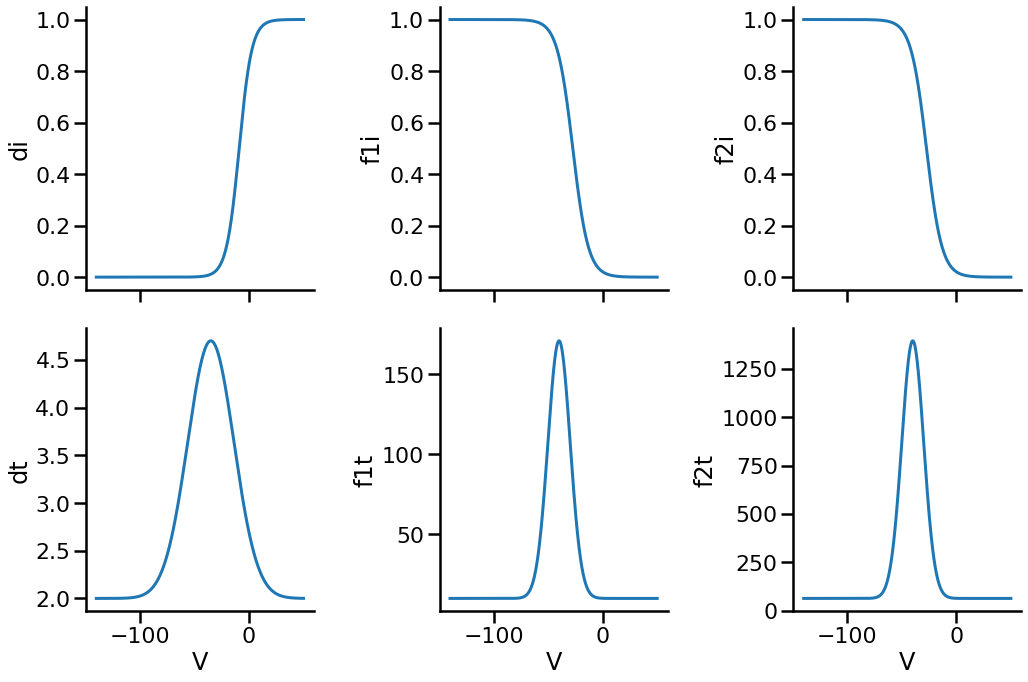

In [26]:
sns.set_context('poster')

V = np.arange(-140, 50, 0.01)

nyg_par_map = {'di': 'ical.d_inf',
            'f1i': 'ical.f_inf',
            'f2i': 'ical.f_inf',
            'dt': 'ical.tau_d',
            'f1t': 'ical.tau_f_1',
            'f2t': 'ical.tau_f_2'}

f, ax = plot_variables(V, nyg_par_map, 'models/nygren_ical.mmt', figshape=(3,2))

# Activation gate ($d$) calibration

Combine model and experiments to produce:
 - observations dataframe
 - model function to run experiments and return traces
 - summary statistics function to accept traces

In [12]:
observations, model, summary_statistics = setup(modelfile,
                                                mewes_act)
assert len(observations)==len(summary_statistics(model({})))

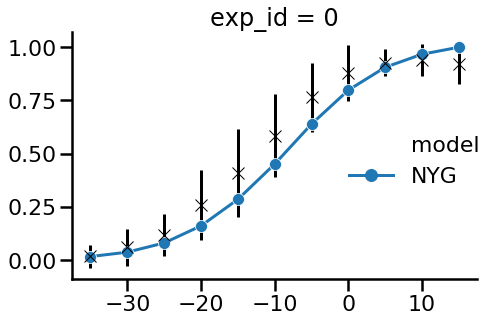

In [13]:
g = plot_sim_results(modelfile,
                     mewes_act)

### Set up prior ranges for each parameter in the model.

See the modelfile for further information on specific parameters. Prepending `log_' has the effect of setting the parameter in log space.

In [16]:
limits = {'ical.p1': (-100, 100),
          'ical.p2': (0, 50),
          'log_ical.p3': (-7, 3),
          'ical.p4': (-100, 100),
          'ical.p5': (0, 50),
          'log_ical.p6': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [17]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [36]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ical_dgate_original.db"))

In [37]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

Test theoretical number of particles for approximately 2 particles per dimension in the initial sampling of the parameter hyperspace.

In [38]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 64 particles


Initialise ABCSMC (see pyABC documentation for further details).

IonChannelDistance calculates the weighting applied to each datapoint based on the experimental variance.

In [39]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 1.8620971283223635, '1': 1.1636171131795543, '2': 1.0342944621090917, '3': 0.6205155126018103, '4': 0.48986542101291475, '5': 0.5170198235080876, '6': 0.6205155126018118, '7': 0.7756730599221309, '8': 1.5522067038604508, '9': 1.3299008007726998, '10': 1.0342944621090833}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [40]:
# Convert observations to dictionary format for calibration
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [41]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-10-17 15:20:25.262537, end_time=None)>


Run calibration with stopping criterion of particle 1\% acceptance rate.

In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0
DEBUG:ABC:population 0 done
DEBUG:ABC:
total nr simulations up to t =0 is 2021
DEBUG:Epsilon:new eps, t=1, eps=1.7467760870612525
INFO:ABC:t:1 eps:1.7467760870612525
DEBUG:ABC:now submitting population 1
DEBUG:ABC:population 1 done
DEBUG:ABC:
total nr simulations up to t =1 is 6104
DEBUG:Epsilon:new eps, t=2, eps=0.8312431374514421
INFO:ABC:t:2 eps:0.8312431374514421
DEBUG:ABC:now submitting population 2
DEBUG:ABC:population 2 done
DEBUG:ABC:
total nr simulations up to t =2 is 12091
DEBUG:Epsilon:new eps, t=3, eps=0.5116924090713459
INFO:ABC:t:3 eps:0.5116924090713459
DEBUG:ABC:now submitting population 3
DEBUG:ABC:population 3 done
DEBUG:ABC:
total nr simulations up to t =3 is 20828
DEBUG:Epsilon:new eps, t=4, eps=0.39913435256168345
INFO:ABC:t:4 eps:0.39913435256168345
DEBUG:ABC:now submitting population 4
DEBUG:ABC:population 4 done
DEBUG:ABC:
total nr simulations up to t =4 is 31083
DEBUG:Epsilon:new eps, t=5, eps=0.3835215

## Analysis of results

In [18]:
history = History('sqlite:///results/nygren/ical/original/nygren_ical_dgate_original.db')

In [20]:
history.all_runs() # ID 2 is the most recent run

[<ABCSMC(id=1, start_time=2019-10-17 13:37:55.916004, end_time=2019-10-17 15:14:02.799840)>,
 <ABCSMC(id=2, start_time=2019-10-17 15:20:25.262537, end_time=2019-10-17 17:16:15.200018)>]

In [21]:
df, w = history.get_distribution()

In [22]:
df.describe()

name,ical.p1,ical.p2,ical.p4,ical.p5,log_ical.p3,log_ical.p6
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,2.660959,5.051521,-11.522957,18.561873,-0.979001,-1.997502
std,0.106361,0.015746,0.066002,0.131535,0.006481,0.017004
min,2.379048,5.004041,-11.700679,18.179155,-1.020526,-2.056282
25%,2.563624,5.041556,-11.581179,18.459250,-0.980587,-2.009898
50%,2.650883,5.053798,-11.528060,18.540711,-0.978655,-1.998095
75%,2.726056,5.063433,-11.477077,18.643031,-0.975676,-1.982758
max,3.010518,5.092141,-11.305433,19.007142,-0.968020,-1.938702


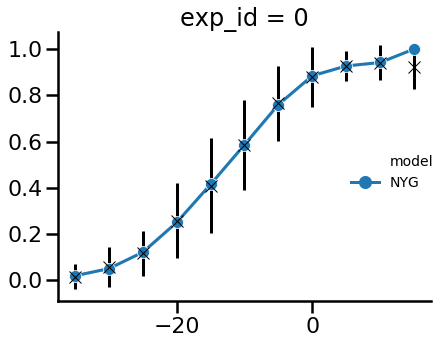

In [23]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     mewes_act,
                     df=df, w=w)

plt.tight_layout()

In [25]:
import pandas as pd
N = 100

nyg_par_samples = df.sample(n=N, weights=w, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

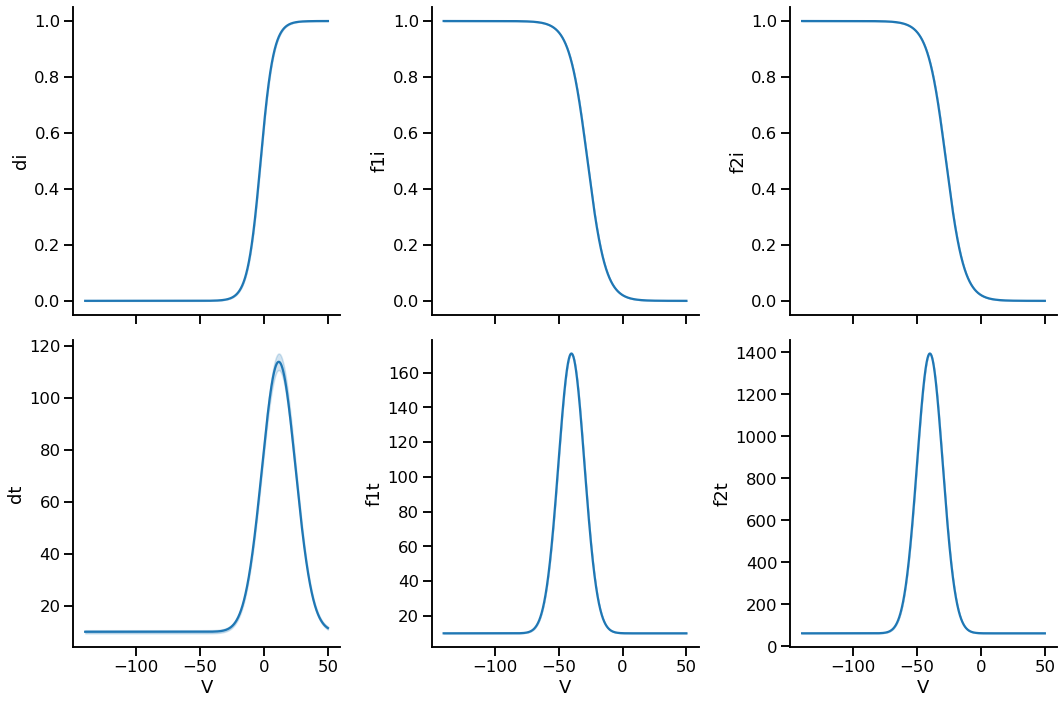

In [27]:
sns.set_context('talk')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_par_map, 
                       'models/nygren_ical.mmt', 
                       [nyg_par_samples],
                       figshape=(3,2))

In [28]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [29]:
m,_,_ = myokit.load(modelfile)

In [30]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

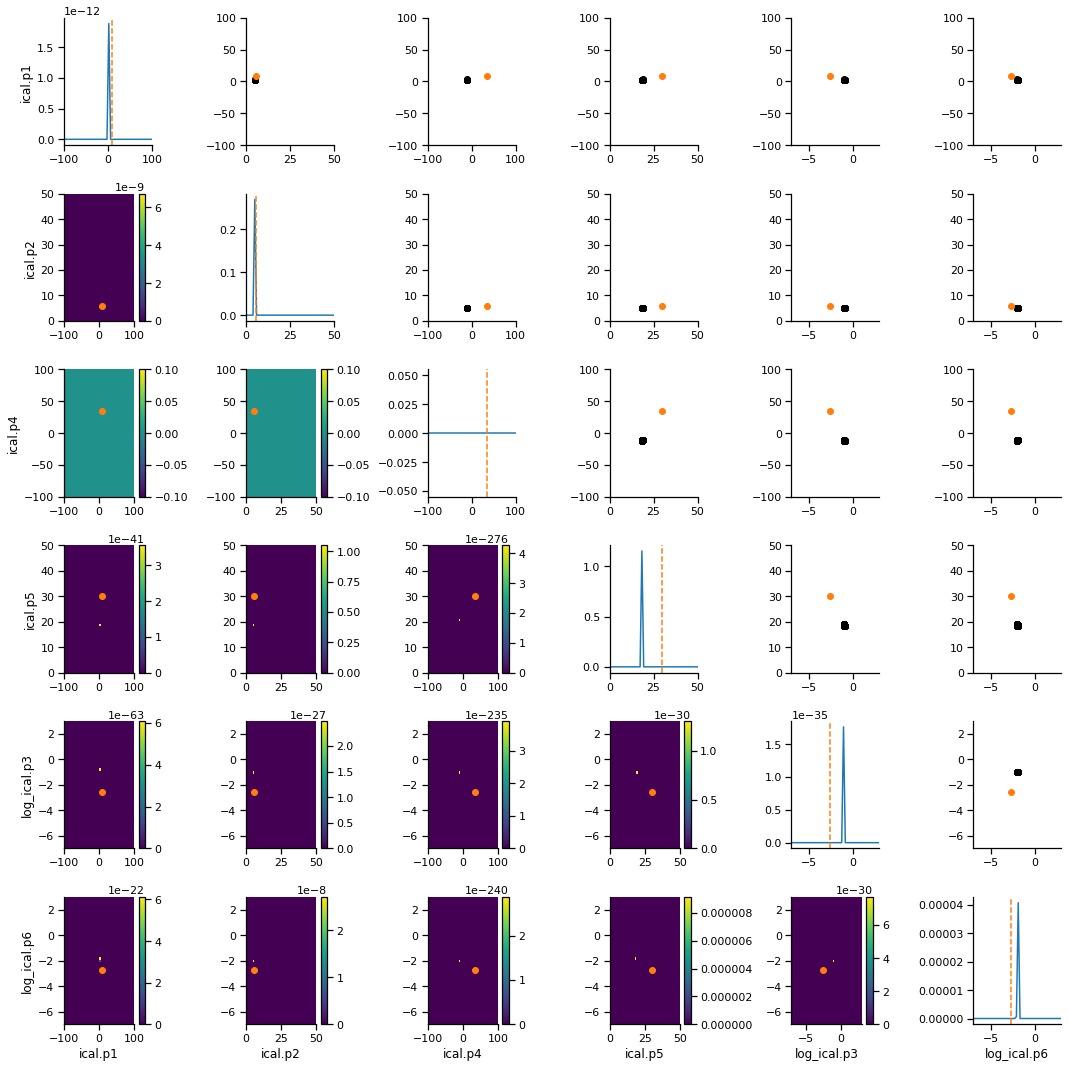

In [31]:
sns.set_context('notebook')
g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

# Voltage-dependent inactivation gate ($f$) calibration

In [32]:
observations, model, summary_statistics = setup(modelfile,
                                                li_inact_1000,
                                                li_inact_kin_80,
                                                li_recov)

In [33]:
assert len(observations)==len(summary_statistics(model({})))

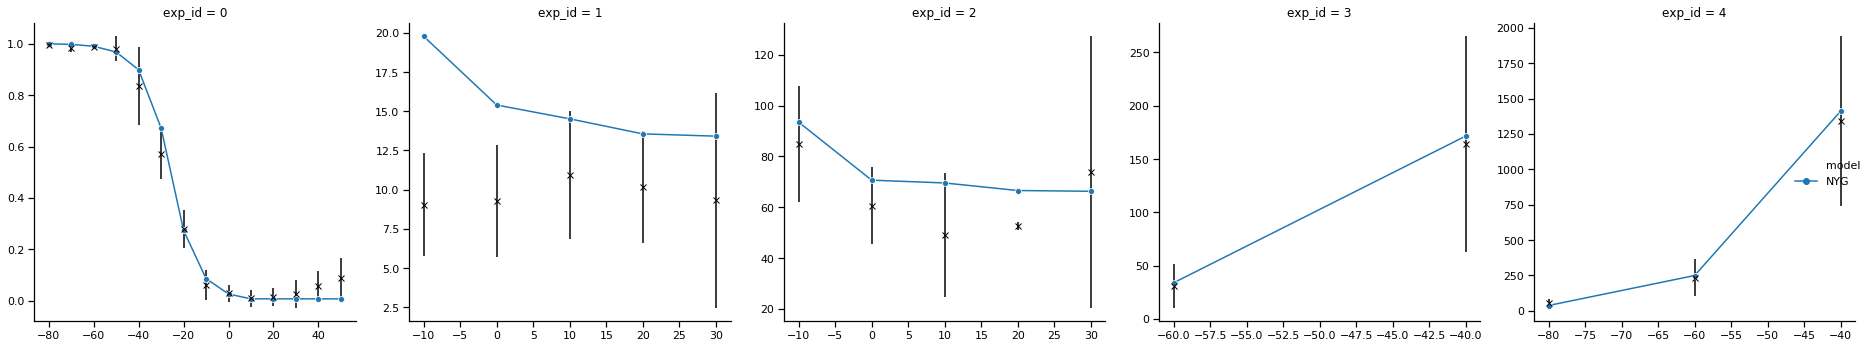

In [34]:
g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov)

In [35]:
limits = {'ical.q1': (0, 100),
          'ical.q2': (0, 50),
          'log_ical.q3': (-7, 3),
          'ical.q4': (0, 100),
          'ical.q5': (0, 50),
          'log_ical.q6': (-7, 3),
          'log_ical.r1': (-7, 3),
          'ical.r2': (0, 100),
          'ical.r3': (0, 100),
          'log_ical.r4': (-7, 3)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [36]:
# Test this works correctly with set-up functions
assert len(observations) == len(summary_statistics(model(prior.rvs())))

### Run ABC calibration

In [83]:
db_path = ("sqlite:///" + os.path.join(tempfile.gettempdir(), "nygren_ical_fgates_original.db"))

In [84]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [85]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [86]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=16),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9837148289810967, '1': 0.9837148289810967, '2': 0.9837148289810967, '3': 0.9837148289810967, '4': 0.3255918060516033, '5': 0.5055241199222262, '6': 0.6753486289586007, '7': 0.8392681990941822, '8': 0.9837148289810967, '9': 0.9837148289810967, '10': 0.9837148289810967, '11': 0.9196236649649016, '12': 0.8392681990941822, '13': 0.6309826606328519, '14': 0.4608478344438249, '15': 0.4184561967200059, '16': 0.36886776090803813, '17': 0.4191992497796024, '18': 0.21952975590454923, '19': 0.5102122707484874, '20': 0.7659862673065287, '21': 0.47913670089197835, '22': 2.754401521147071, '23': 0.21885528270246785, '24': 2.749064693405502, '25': 0.5560031468540616, '26': 4.590669201911785, '27': 2.354305935366494, '28': 0.5128531003233773}
DEBUG:Epsilon:init quantile_epsilon initial_epsilon=100, quantile_multiplier=1


In [87]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [88]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=1, start_time=2019-10-17 19:52:53.526379, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=10, min_acceptance_rate=0.01)

INFO:ABC:t:15 eps:0.9133478412862602
DEBUG:ABC:now submitting population 15


### Database results analysis

In [37]:
history = History('sqlite:///results/nygren/ical/original/nygren_ical_fgates_original.db')

In [38]:
df, w = history.get_distribution(m=0)

In [39]:
df.describe()

name,ical.q1,ical.q2,ical.q4,ical.q5,ical.r2,ical.r3,log_ical.q3,log_ical.q6,log_ical.r1,log_ical.r4
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,30.156166,6.730771,56.580411,23.334852,54.395752,54.832247,-2.131878,-1.959613,-2.108995,-2.403978
std,5.948294,3.895447,22.420511,12.545286,24.090537,28.558573,1.857617,0.454193,1.656196,1.362117
min,13.211088,0.017653,0.216687,0.043591,0.010249,0.037943,-6.974644,-2.811407,-6.984885,-6.989402
25%,26.050785,3.938361,41.640631,12.816047,38.325957,29.253013,-3.090123,-2.285906,-2.632827,-2.660907
50%,29.774425,6.137597,56.170570,22.703646,54.850311,58.982160,-1.592925,-2.169347,-1.507725,-2.142585
75%,33.660764,9.061450,73.908358,33.527269,73.243798,79.371396,-0.829485,-1.346971,-0.984876,-1.335018
max,58.549670,25.120795,99.953634,49.910397,99.918826,99.976274,2.906673,-1.156871,1.358781,-1.161396


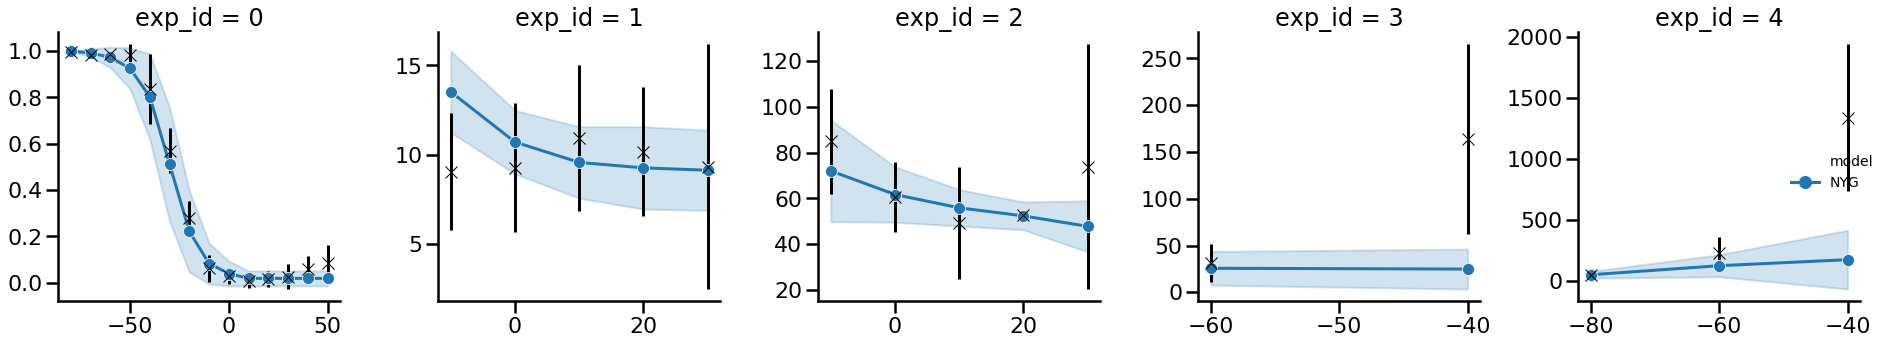

In [40]:
sns.set_context('poster')

mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

g = plot_sim_results(modelfile,
                     li_inact_1000,
                     li_inact_kin_80,
                     li_recov,
                     df=df, w=w)

plt.tight_layout()

In [41]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [42]:
m,_,_ = myokit.load(modelfile)

In [43]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

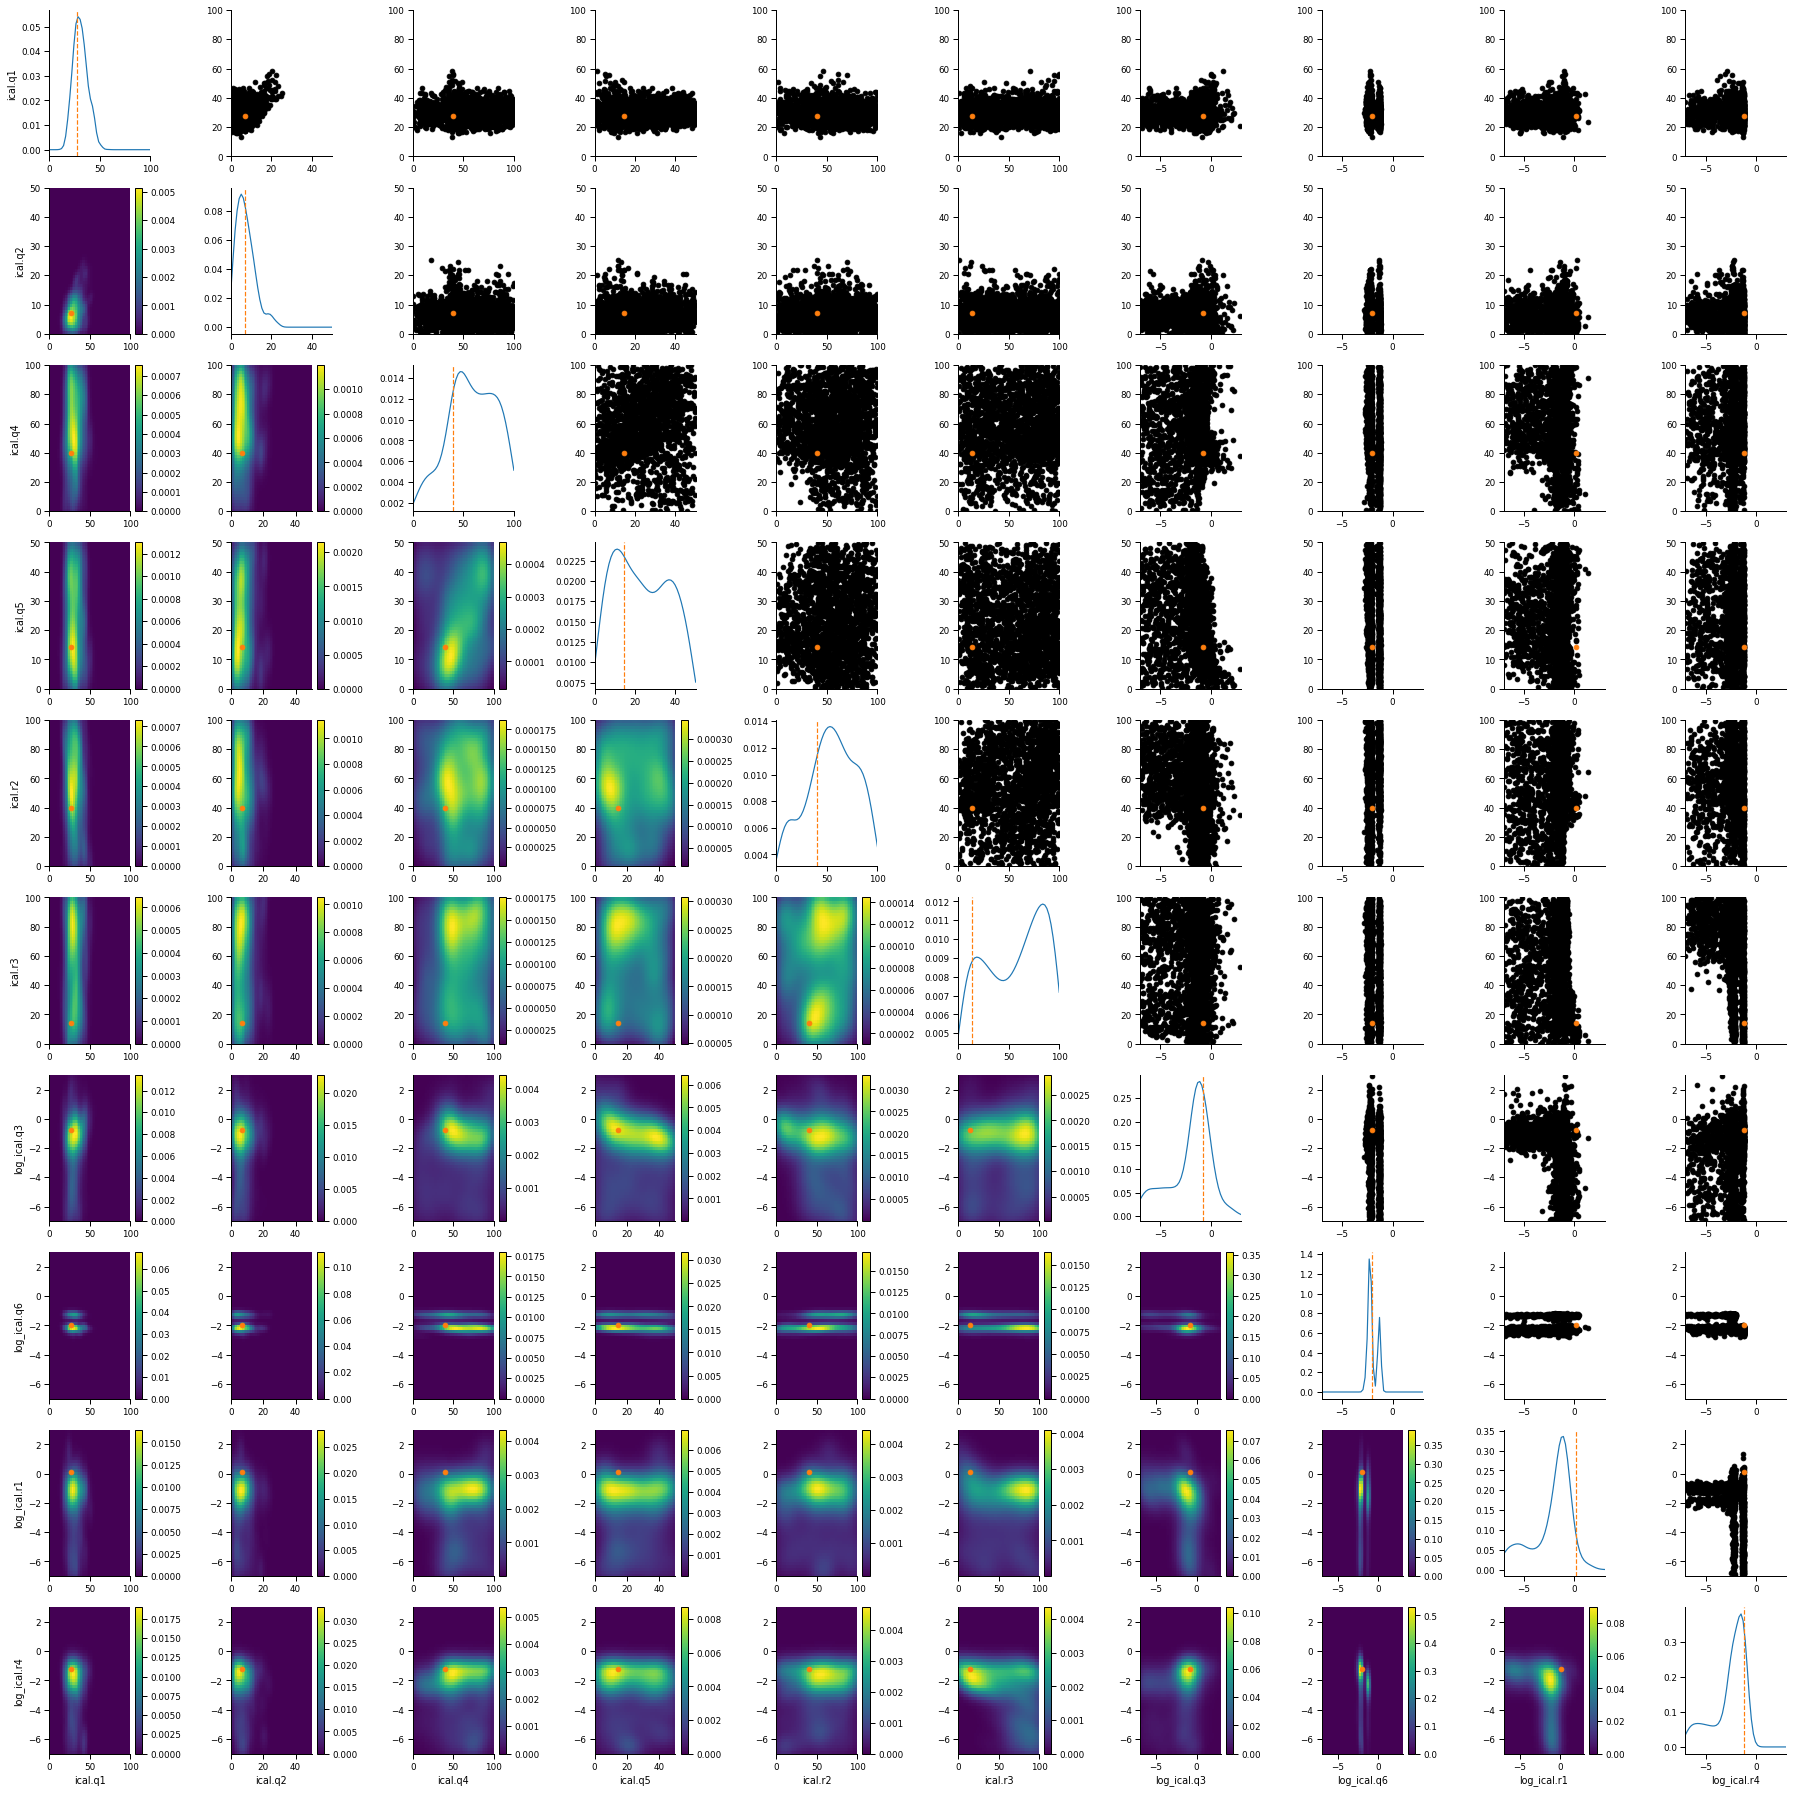

In [44]:
sns.set_context('paper')

g = plot_kde_matrix_custom(df, w, limits=limits, refval=originals)

plt.tight_layout()

In [45]:
N = 100
nyg_par_samples = df.sample(n=N, weights=w, replace=True)
nyg_par_samples = nyg_par_samples.set_index([pd.Index(range(N))])
nyg_par_samples = nyg_par_samples.to_dict(orient='records')

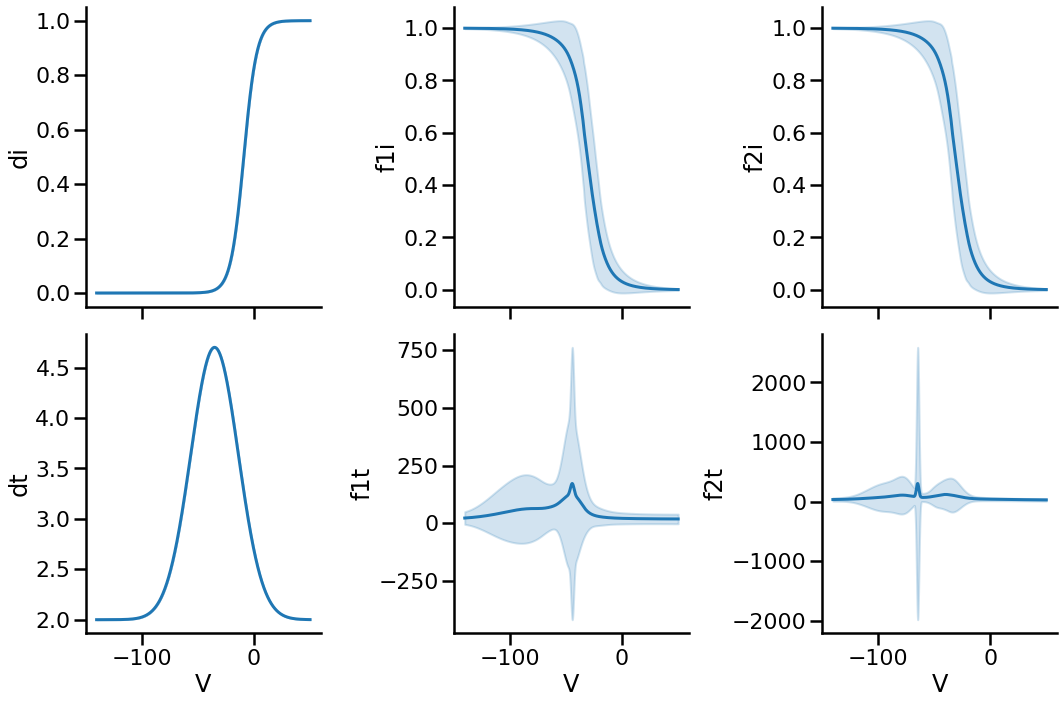

In [46]:
sns.set_context('poster')
mpl.rcParams['font.size'] = 14
mpl.rcParams['legend.fontsize'] = 14

f, ax = plot_variables(V, nyg_par_map, 
                       'models/nygren_ical.mmt', 
                       [nyg_par_samples],
                       figshape=(3,2))

plt.tight_layout()